In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [20]:
import numpy as np
import pandas as pd

In [21]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [23]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [24]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [25]:
# We can view all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [26]:
#find column names for measuremnt 
measurement_cols = inspector.get_columns('measurement')
for cols in measurement_cols:
    print(cols['name'], cols["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [27]:
station_cols = inspector.get_columns('station')
for cols in station_cols:
    print(cols['name'], cols["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [28]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [29]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [30]:
# view the structure of the table station 
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [31]:
# view the structure of the table station 
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

<Figure size 720x504 with 0 Axes>

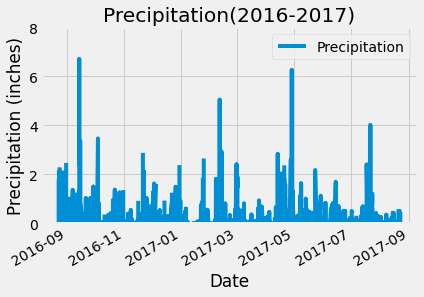

In [49]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

latest_date= (session.query(Measurement.date).order_by(Measurement.date.desc()).first())[0]

#find a year ago from latest date
year_ago = dt.datetime.strptime(latest_date, "%Y-%m-%d")- dt.timedelta(days=366)
#this gets the most recent date in the measurement table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#query to retrieve the last 12 months of precipitation data
last12months=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=year_ago).all()

#Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(last12months, columns = ["date", "Precipitation"])
prcp_df["date"] = pd.to_datetime(prcp_df["date"], format = "%Y-%m-%d")
prcp_df.set_index("date", inplace = True)


# Sort the dataframe by date

prcp_df = prcp_df.sort_values(by="date", ascending = True)
prcp_df

#print(last12months)

# Use Pandas Plotting with Matplotlib to plot the data

x= prcp_df.index.to_list()
y= prcp_df['Precipitation'].tolist()

fig=plt.figure(figsize=(10,7))
prcp_df.plot(title="Precipitation(2016-2017)")
plt.ylim(0,8)

plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.savefig("Images/Precipitation.png", bbox_inches="tight")
plt.show()

In [50]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [52]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Measurement.station).distinct().count()
print(f"There are {num_stations} stations in this dataset.")


There are 9 stations in this dataset.


In [53]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
mostActiveStation = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
mostActiveStation

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [63]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active = mostActiveStation[0][0]


lowestTemp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == active).all()
highestTemp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == active).all()
avgTemp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == active).all()
print (lowestTemp , highestTemp , avgTemp)


[(54.0,)] [(85.0,)] [(71.66378066378067,)]


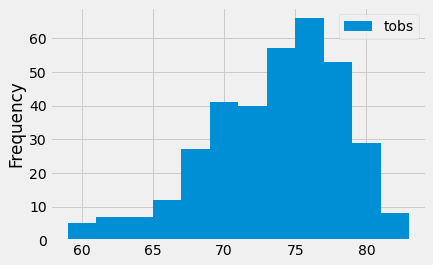

In [69]:
# Choose the station with the highest number of temperature observations.
most_temp_obs = mostActiveStation[0][0]
#most_temp_obs

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_12months = session.query(Measurement.tobs).filter(Measurement.date>=year_ago).filter(Measurement.station == most_temp_obs).all()
temp_12months[:10]

popularStationDF = pd.DataFrame(temp_12months)
popularStationDF.plot(kind="hist", bins=12)

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
